# Image Segmentation Model - MONAI

##### Imports

In [1]:
import torch
import monai
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    LoadImaged,
    RandSpatialCrop,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.networks.nets import BasicUNetPlusPlus
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import CacheDataset, DataLoader, Dataset, ImageReader, MetaTensor
from monai.inferers import sliding_window_inference
from monai.transforms import Activations, AsDiscrete, KeepLargestConnectedComponent
from monai.visualize import plot_2d_or_3d_image
monai.utils.set_determinism(17)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

from skimage.io import imread, imsave, imshow

from tqdm import tqdm

import datetime

##### Hyperparamters

In [2]:
batch_size = 4
num_workers = 4
learning_rate = 0.0005
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Dataset Creation

In [3]:
class CellDataset(Dataset):
    def __init__(self, data_dir, train=True):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'image')
        self.mask_dir = os.path.join(data_dir, 'mask')
        self.image_files = os.listdir(self.image_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform_list = [
            RandFlip(prob=1, spatial_axis=0),
            RandFlip(prob=1, spatial_axis=1),
            RandRotate(prob=1, range_y=[1.57, 1.57]),
            RandRotate(prob=1, range_y=[4.71, 4.71])
        ]

        if train:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
        else:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
            self.image_files, self.test_image_files = self.test_image_files, self.image_files
            self.mask_files, self.test_mask_files = self.test_mask_files, self.mask_files
        
        self.temp_image_file = []
        self.temp_mask_file = []
        
        for image_path, mask_path in zip(self.image_files, self.mask_files):
            image_path = os.path.join(self.image_dir, image_path)
            mask_path = os.path.join(self.mask_dir, mask_path)
            image = MetaTensor(imread(image_path))
            mask = MetaTensor(imread(mask_path)).unsqueeze(0)
            self.temp_image_file.append(image)
            self.temp_mask_file.append(mask)
            for transform in self.transform_list:
                self.temp_image_file.append(transform(image))
                self.temp_mask_file.append(transform(mask))
        
        self.image_files, self.mask_files = self.temp_image_file, self.temp_mask_file

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        image = self.image_files[index].float()
        mask = torch.where(self.mask_files[index].float() == 0, 0.0, 1.0)

        return image, mask

In [4]:
DATA_DIR = r"D:\multiplexed-immunofluorescence-instance-segmentation\data\final"
train_dataset = CellDataset(DATA_DIR)
test_dataset = CellDataset(DATA_DIR, train=False)

In [5]:
train_dataset.__len__(), test_dataset.__len__()

(530, 135)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=torch.cuda.is_available())

In [7]:
len(train_loader), len(test_loader)

(133, 34)

##### Model Definition - UNet

In [8]:
in_channels = 8
out_channels = 1
model = BasicUNetPlusPlus(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=out_channels,
    features=(16, 32, 64, 128, 64, 32),
).to(device)
print(model)

BasicUNetPlusPlus features: (16, 32, 64, 128, 64, 32).
BasicUNetPlusPlus(
  (conv_0_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (conv_1_0): Down(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1

##### Loss Function and Optimizer

In [9]:
criterion = DiceLoss(sigmoid=True, jaccard=True)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

##### Training Loop

In [10]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)[0]
        # Compute the loss
        loss = criterion(outputs, masks)
        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)[0]

            # Compute the loss
            loss = criterion(outputs, masks)

            test_loss += loss.item() * images.size(0)

        test_loss /= len(test_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  3%|▎         | 1/30 [01:20<38:50, 80.35s/it]

Epoch 1/30, Train Loss: 0.3773, Test Loss: 0.3033


  7%|▋         | 2/30 [02:35<35:57, 77.05s/it]

Epoch 2/30, Train Loss: 0.3002, Test Loss: 0.2624


 10%|█         | 3/30 [03:50<34:25, 76.50s/it]

Epoch 3/30, Train Loss: 0.2692, Test Loss: 0.2403


 13%|█▎        | 4/30 [05:06<33:04, 76.32s/it]

Epoch 4/30, Train Loss: 0.2526, Test Loss: 0.2284


 17%|█▋        | 5/30 [06:24<32:02, 76.92s/it]

Epoch 5/30, Train Loss: 0.2416, Test Loss: 0.2297


 20%|██        | 6/30 [07:43<31:03, 77.63s/it]

Epoch 6/30, Train Loss: 0.2352, Test Loss: 0.2210


 23%|██▎       | 7/30 [09:08<30:40, 80.03s/it]

Epoch 7/30, Train Loss: 0.2315, Test Loss: 0.2197


 27%|██▋       | 8/30 [10:32<29:45, 81.14s/it]

Epoch 8/30, Train Loss: 0.2309, Test Loss: 0.2183


 30%|███       | 9/30 [12:00<29:07, 83.20s/it]

Epoch 9/30, Train Loss: 0.2266, Test Loss: 0.2152


 33%|███▎      | 10/30 [13:20<27:27, 82.37s/it]

Epoch 10/30, Train Loss: 0.2211, Test Loss: 0.2139


 37%|███▋      | 11/30 [14:44<26:12, 82.78s/it]

Epoch 11/30, Train Loss: 0.2196, Test Loss: 0.2153


 40%|████      | 12/30 [16:10<25:09, 83.85s/it]

Epoch 12/30, Train Loss: 0.2201, Test Loss: 0.2151


 43%|████▎     | 13/30 [17:31<23:31, 83.01s/it]

Epoch 13/30, Train Loss: 0.2164, Test Loss: 0.2185


 47%|████▋     | 14/30 [19:00<22:37, 84.86s/it]

Epoch 14/30, Train Loss: 0.2157, Test Loss: 0.2159


 50%|█████     | 15/30 [20:29<21:29, 86.00s/it]

Epoch 15/30, Train Loss: 0.2153, Test Loss: 0.2150


 53%|█████▎    | 16/30 [21:58<20:15, 86.82s/it]

Epoch 16/30, Train Loss: 0.2138, Test Loss: 0.2187


 57%|█████▋    | 17/30 [23:29<19:05, 88.11s/it]

Epoch 17/30, Train Loss: 0.2106, Test Loss: 0.2162


 60%|██████    | 18/30 [25:12<18:29, 92.47s/it]

Epoch 18/30, Train Loss: 0.2114, Test Loss: 0.2130


 63%|██████▎   | 19/30 [26:55<17:32, 95.64s/it]

Epoch 19/30, Train Loss: 0.2072, Test Loss: 0.2190


 67%|██████▋   | 20/30 [28:22<15:32, 93.25s/it]

Epoch 20/30, Train Loss: 0.2093, Test Loss: 0.2148


 70%|███████   | 21/30 [29:55<13:57, 93.10s/it]

Epoch 21/30, Train Loss: 0.2070, Test Loss: 0.2165


 73%|███████▎  | 22/30 [31:30<12:30, 93.76s/it]

Epoch 22/30, Train Loss: 0.2041, Test Loss: 0.2139


 77%|███████▋  | 23/30 [33:11<11:10, 95.79s/it]

Epoch 23/30, Train Loss: 0.2045, Test Loss: 0.2166


 80%|████████  | 24/30 [34:48<09:36, 96.15s/it]

Epoch 24/30, Train Loss: 0.2023, Test Loss: 0.2214


 83%|████████▎ | 25/30 [36:24<08:00, 96.03s/it]

Epoch 25/30, Train Loss: 0.2006, Test Loss: 0.2139


 87%|████████▋ | 26/30 [38:02<06:27, 96.81s/it]

Epoch 26/30, Train Loss: 0.1988, Test Loss: 0.2141


 90%|█████████ | 27/30 [39:40<04:50, 96.97s/it]

Epoch 27/30, Train Loss: 0.1967, Test Loss: 0.2152


 93%|█████████▎| 28/30 [41:21<03:16, 98.32s/it]

Epoch 28/30, Train Loss: 0.1961, Test Loss: 0.2199


 97%|█████████▋| 29/30 [42:57<01:37, 97.53s/it]

Epoch 29/30, Train Loss: 0.1935, Test Loss: 0.2177


100%|██████████| 30/30 [44:33<00:00, 89.12s/it]

Epoch 30/30, Train Loss: 0.1927, Test Loss: 0.2176


In [11]:
# Save the trained model
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"segmentation_model_monai_unetpp_{timestamp}.pth"
save_path = f"../models/segmentation_model/{model_name}"
torch.save(model.state_dict(), save_path)

In [12]:
image, mask = test_dataset.__getitem__(30)

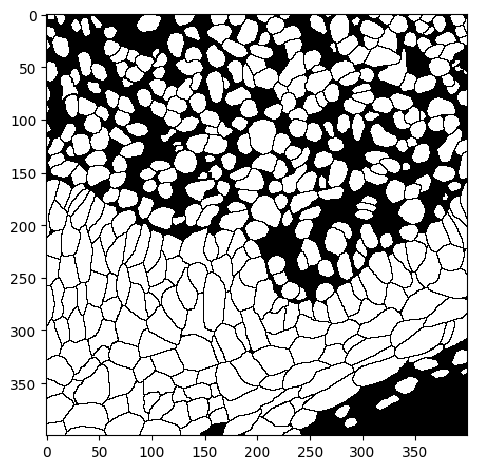

In [13]:
imshow(mask.squeeze().numpy(), cmap="gray")

In [14]:
sam_output = model(image.unsqueeze(0).to(device))

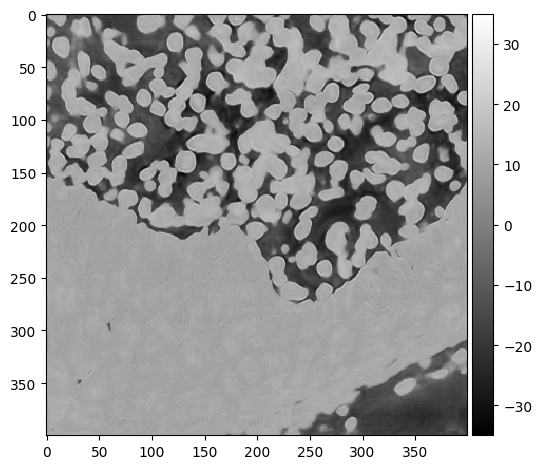

In [16]:
imshow(sam_output[0].squeeze().detach().cpu().numpy(), cmap="gray")

In [18]:
scaled_tensor = (sam_output[0] - torch.min(sam_output[0])) * (1.0 / (torch.max(sam_output[0]) - torch.min(sam_output[0])))

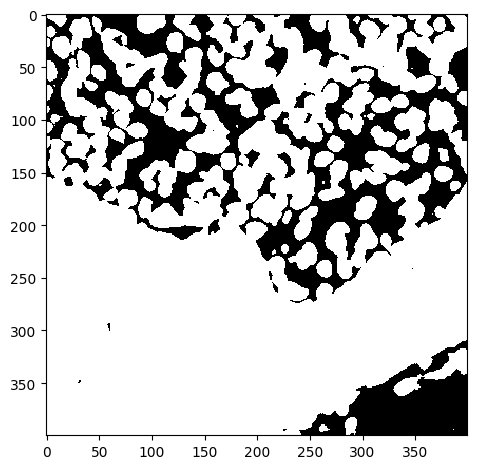

In [19]:
imshow(torch.round(scaled_tensor).detach().cpu().numpy().squeeze(), cmap='gray')